## Import all necessary libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
pd.set_option("display.max_rows", None, "display.max_columns", None)

## How it all works

In [6]:
def read_file(filename):
    try:
        return pd.read_csv(filename, usecols=['word_form', 'lemma', 'pos'])
    except FileNotFoundError:
        print(f"Error: File '{filename}' not found.")
        return None

In [7]:
sample1 = read_file("lem_pos_first.csv")
sample2 = read_file("lem_pos_second.csv")

In [8]:
sample1.head()

,word_form,lemma,pos
0,ярослав,ярослав,NOUN
1,грицак,грицак,NOUN
2,нариси,нарис,NOUN
3,з,з,PREP
4,історії,історія,NOUN


In [9]:
sample2.head()

,word_form,lemma,pos
0,веселий,веселий,ADJF
1,цвинтар,цвинтар,NOUN
2,над,над,PREP
3,осіннім,осінній,ADJF
4,озером,озеро,NOUN


### Build frequency dictionaries based on samples

In [10]:
def create_frequency_dictionaries(dataframe, fields=['lemma', 'word_form', 'pos']):
    """
    Create frequency dictionaries for specified fields in the given dataframe.

    Parameters:
    dataframe (pandas.DataFrame): The input dataframe containing relevant data.
    fields (list): List of fields to create frequency dictionaries for. Default is ['lemma', 'word_form', 'pos'].

    Returns:
    list of pandas.Series: A list of frequency dictionaries for each specified field.
                           Each dictionary contains field values as keys and their respective
                           frequencies as values, sorted in descending order.
    """
    fd_dicts = [dataframe.groupby(field)[field].count().sort_values(ascending=False) for field in fields]
    return fd_dicts

In [11]:
fd_lemma1, fd_wordform1, fd_pos1 = create_frequency_dictionaries(sample1)
fd_lemma2, fd_wordform2, fd_pos2 = create_frequency_dictionaries(sample2)

### Build frequency dictionaries based on subsamples

In [13]:
def divide_into_subsamples(dataframe, num_subsamples=20, subsample_size=1000, random_state=2):
    """
    Divide a DataFrame into approximately equal-sized subsamples.

    Parameters:
    dataframe (pandas.DataFrame): The input DataFrame to be divided.
    num_subsamples (int): Number of subsamples to create. Default is 20.
    subsample_size (int): Size of each subsample. Default is 1000.
    random_state (int or None): Random seed for reproducibility. Default is 2.

    Returns:
    list of pandas.DataFrame: A list containing subsamples of the input DataFrame.
    """
    # Shuffle the data to ensure randomness
    shuffled = dataframe.sample(frac=1, random_state=random_state)
    
    # Divide the shuffled data into subsamples
    subsamples = np.array_split(shuffled, num_subsamples)
    
    return subsamples

In [14]:
def fd_subsample(subsamples):
    """
    Calculate frequency dictionaries for lemma, word form, and part-of-speech (POS)
    based on a list of subsamples.

    Parameters:
    subsamples (list of pandas.DataFrame): A list containing 20 subsamples of data.

    Returns:
    tuple: A tuple containing three lists of frequency dictionaries - one for lemma,
           one for word form, and one for part-of-speech (POS).
    """
    fd_lemma = []
    fd_wordform = []
    fd_pos = []

    for subsample in subsamples:
        fd_lemma.append(subsample['lemma'].value_counts().to_dict())
        fd_wordform.append(subsample['word_form'].value_counts().to_dict())
        fd_pos.append(subsample['pos'].value_counts().to_dict())

    return fd_lemma, fd_wordform, fd_pos

In [15]:
subsamples_1 = divide_into_subsamples(sample1)
subsamples_2 = divide_into_subsamples(sample2)

fd_lemmas1, fd_wordforms1, fd_poses1 = fd_subsample(subsamples_1)
fd_lemmas2, fd_wordforms2, fd_poses2 = fd_subsample(subsamples_2)

In [16]:
def abs_freq_dist(subsamples, column, search_option):
    """
    Calculate absolute frequency distribution for a specified column and search option in each subsample.

    Parameters:
    subsamples (list of pandas.DataFrame): A list of subsamples containing data.
    column (str): The column to search for the specified option (lemma, word_form, pos).
    search_option (str): The option to search for in the specified column (POS tag, wordform, lemma).

    Returns:
    pandas.DataFrame: A DataFrame containing absolute frequency distribution for each subsample.
    """
    absolute_frequencies = [sub_sample[column].eq(search_option).sum() for sub_sample in subsamples]
    abs_f = pd.DataFrame(absolute_frequencies, columns=['Xi'], index=range(1, len(subsamples) + 1))

    grouped_abs = abs_f['Xi'].value_counts().reset_index()
    grouped_abs.columns = ['Xi', 'Ni']
    grouped_abs = grouped_abs.sort_values(by='Xi')

    return abs_f, grouped_abs

def plot_abs_freq_distribution(grouped):
    """
    Plot the absolute frequency distribution.

    Parameters:
    grouped (pandas.DataFrame): DataFrame containing absolute frequency distribution.
    custom_title (str): Custom title for the plot.
    """
    plt.plot(grouped['Xi'], grouped['Ni'])
    plt.fill_between(grouped['Xi'], grouped['Ni'], color='skyblue', alpha=0.4)  # Fill area under the curve
    plt.xlabel("Xi variant")
    plt.ylabel("Ni variant frequency")
    plt.show()

In [17]:
def rel_freq_dist(subsamples, column, search_option, total_size=1000):
    """
    Calculate average relative frequency.

    Parameters:
    subsamples (list of pandas.DataFrame): A list of subsamples containing data.
    column (str): The column to search for the specified option (lemma, word_form, pos).
    search_option (str): The option to search for in the specified column (POS tag, wordform, lemma).
    total_size (int): The total size of each subsample. Default is 1000.

    Returns:
    float: The average relative frequency for the specified option.
    """
    absolute_frequencies = [sub_sample[sub_sample[column] == search_option].shape[0] for sub_sample in subsamples]

    relative_frequencies = np.array(absolute_frequencies) / total_size

    avg_relative_frequency = np.mean(relative_frequencies)

    return avg_relative_frequency

In [18]:
def count_prestats(subsamples, frequency_dictionary, column, search_option):
    """
    Calculate pre-statistics needed for mean squared error.

    Parameters:
    subsamples (list of pandas.DataFrame): A list of subsamples containing data.
    frequency_dictionary (pandas.core.series.Series): A frequency dictionary created based on sample.
    column (str): The column to search for the specified option (lemma, word_form, pos).
    search_option (str): The option to search for in the specified column (POS tag, wordform, lemma).

    Returns:
    pandas.DataFrame: DataFrame containing pre-statistics.
    """
    
    pre_stats = abs_freq_dist(subsamples, column, search_option)[1]

    # Calculate additional pre-statistics
    pre_stats['XiNi'] = pre_stats['Xi'] * pre_stats['Ni']
    x̄_value = pre_stats['XiNi'].sum() / pre_stats['Ni'].sum()
    pre_stats['x̄'] = x̄_value

    pre_stats['Xi - x̄'] = pre_stats['Xi'] - x̄_value
    pre_stats['(Xi - x̄)²'] = (pre_stats['Xi - x̄']) ** 2
    pre_stats['(Xi - x̄)²Ni'] = pre_stats['(Xi - x̄)²'] * pre_stats['Ni']
    
    pre_stats.insert(loc=0, column='m', value=[frequency_dictionary[search_option]] + [''] * (len(pre_stats) - 1))
    pre_stats.insert(loc=1, column='p', value=[frequency_dictionary[search_option] / 20000] + [''] * (len(pre_stats) - 1))
    pre_stats.insert(loc=2, column='p-bar', value=[rel_freq_dist(subsamples, column, search_option)] + [''] * (len(pre_stats) - 1))

#     # Create DataFrame for totals row for Xi, Ni, XiNi only
#     totals_row = pd.DataFrame(pre_stats[['Xi', 'Ni', 'XiNi']].sum()).T
#     totals_row.index = [f"Σ = "]
    
#     # Concatenate totals row to the original DataFrame
#     pre_stats = pd.concat([pre_stats, totals_row])

    return pre_stats.round(2)

In [19]:
def other_statistics(prestats):
    """
    Calculate additional statistics based on prestatistics.

    Parameters:
    prestats (pandas.core.frame.DataFrame): DataFrame containing prestatistics.

    Returns:
    pandas.core.frame.DataFrame: DataFrame containing additional statistics.
    """
    prestats_copy = prestats.copy()

    # Calculate standard deviation (σ) for the first row only
    σ = math.sqrt(prestats["(Xi - x̄)²Ni"].sum() / prestats["Ni"].sum())
    prestats_copy.loc[prestats_copy.index[0], 'σ'] = σ

    # Calculate confidence interval 2σ for the first row only
    x̄ = prestats_copy.loc[prestats_copy.index[0], 'x̄']
    prestats_copy.loc[prestats_copy.index[0], 'x̄ - 2σ'] = x̄ - 2 * σ
    prestats_copy.loc[prestats_copy.index[0], 'x̄ + 2σ'] = x̄ + 2 * σ

    # Calculate measure of fluctuation of the average frequency (σx̄) for the first row only
    σx̄ = σ / math.sqrt(prestats["Ni"].iloc[:-1].sum())
    prestats_copy.loc[prestats_copy.index[0], 'σx̄'] = σx̄

    # Calculate confidence interval 2σx̄ for the first row only
    prestats_copy.loc[prestats_copy.index[0], 'x̄ - 2σx̄'] = x̄ - 2 * σx̄
    prestats_copy.loc[prestats_copy.index[0], 'x̄ + 2σx̄'] = x̄ + 2 * σx̄

    # Calculate coefficient of variation (v) for the first row only
    v = σ / x̄
    prestats_copy.loc[prestats_copy.index[0], 'v'] = v

    # Calculate maximum coefficient of variation (Vmax) for the first row only
    Vmax = math.sqrt(prestats["Ni"].sum() - 1)
    prestats_copy.loc[prestats_copy.index[0], 'Vmax'] = Vmax

    # Calculate stability coefficient (D) for the first row only
    D = 1 - (v / Vmax)
    prestats_copy.loc[prestats_copy.index[0], 'D'] = D

    # Calculate relative error of the study (E) for the first row only
    E = (1.96 / math.sqrt(prestats["Ni"].sum())) * v
    prestats_copy.loc[prestats_copy.index[0], 'E'] = E

    return prestats_copy.round(2)

In [20]:
# subsamples_1, subsamples_2
# fd_wordform1, fd_wordform2 - fd_lemma1, fd_lemma2 - fd_pos1, fd_pos2
# word_form, lemma, pos
# землі, земля, NOUN

In [21]:
def prettify_dataframe(dataframe):
    dataframe.reset_index(drop=True, inplace=True)
    dataframe.index += 1
    return dataframe.fillna('')

In [36]:
prettify_dataframe(count_prestats(subsamples_1, fd_pos1, 'pos', 'NOUN'))

,m,p,p-bar,Xi,Ni,XiNi,x̄,Xi - x̄,(Xi - x̄)²,(Xi - x̄)²Ni
1,7350,0.3675,0.3675,334,1,334,367.5,-33.5,1122.25,1122.25
2,,,,342,1,342,367.5,-25.5,650.25,650.25
3,,,,348,1,348,367.5,-19.5,380.25,380.25
4,,,,354,1,354,367.5,-13.5,182.25,182.25
5,,,,357,1,357,367.5,-10.5,110.25,110.25
6,,,,361,1,361,367.5,-6.5,42.25,42.25
7,,,,363,2,726,367.5,-4.5,20.25,40.50
8,,,,364,2,728,367.5,-3.5,12.25,24.50
9,,,,366,1,366,367.5,-1.5,2.25,2.25
10,,,,368,1,368,367.5,0.5,0.25,0.25


In [37]:
prettify_dataframe(other_statistics(count_prestats(subsamples_1, fd_pos1, 'pos', 'NOUN')))

,m,p,p-bar,Xi,Ni,XiNi,x̄,Xi - x̄,(Xi - x̄)²,(Xi - x̄)²Ni,σ,x̄ - 2σ,x̄ + 2σ,σx̄,x̄ - 2σx̄,x̄ + 2σx̄,v,Vmax,D,E
1,7350,0.3675,0.3675,334,1,334,367.5,-33.5,1122.25,1122.25,16.72,334.07,400.93,3.84,359.83,375.17,0.05,4.36,0.99,0.02
2,,,,342,1,342,367.5,-25.5,650.25,650.25,,,,,,,,,,
3,,,,348,1,348,367.5,-19.5,380.25,380.25,,,,,,,,,,
4,,,,354,1,354,367.5,-13.5,182.25,182.25,,,,,,,,,,
5,,,,357,1,357,367.5,-10.5,110.25,110.25,,,,,,,,,,
6,,,,361,1,361,367.5,-6.5,42.25,42.25,,,,,,,,,,
7,,,,363,2,726,367.5,-4.5,20.25,40.50,,,,,,,,,,
8,,,,364,2,728,367.5,-3.5,12.25,24.50,,,,,,,,,,
9,,,,366,1,366,367.5,-1.5,2.25,2.25,,,,,,,,,,
10,,,,368,1,368,367.5,0.5,0.25,0.25,,,,,,,,,,


## Polygons for absolute frequencies and interval distribution of absolute frequencies

Enter the number of the subsample (1 or 2): 1
Enter the attribute name (word_form, lemma, or pos): pos
Enter the value for the attribute variable: NOUN


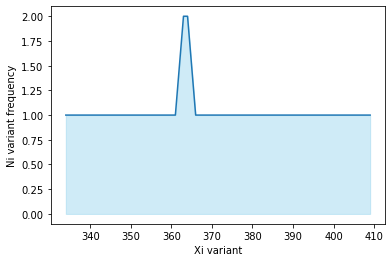

In [38]:
subsamples_values = {'1': subsamples_1, '2': subsamples_2}
attribute_values = {'word_form': [fd_wordform1, fd_wordform2], 'lemma': [fd_lemma1, fd_lemma2], 'pos': [fd_pos1, fd_pos2]}
valid_attribute_names = ['word_form', 'lemma', 'pos']

def get_user_input():
    while True:
        subsample_number = input("Enter the number of the subsample (1 or 2): ")
        if subsample_number not in subsamples_values:
            print("Invalid subsample number. Please enter '1' or '2'.")
            continue
        
        attribute_name = input("Enter the attribute name (word_form, lemma, or pos): ")
        if attribute_name not in valid_attribute_names:
            print("Invalid attribute name. Please enter 'word_form', 'lemma', or 'pos'.")
            continue

        value = input(f"Enter the value for the attribute variable: ")
        break
    if subsample_number == 1:
        return subsamples_values[subsample_number], attribute_name, value
    return subsamples_values[subsample_number], attribute_name, value
        

def plot_user_defined_distribution():
    subsample, attribute_name, value = get_user_input()
    abs_freq_distribution = abs_freq_dist(subsample, attribute_name, value)[1]
    if abs_freq_distribution.shape[0] == 1:
        print("No occurences of the attribute value were foudnd")
    else:
        plot_abs_freq_distribution(abs_freq_distribution)

# Example usage:
plot_user_defined_distribution()

In [29]:
def plot_interval_intersection(sample_intervals, custom_title):
    """
    Plot intervals for two samples and visualize their intersection.

    Parameters:
    sample_intervals (list of tuples): List of tuples representing confidence intervals for two samples.
    custom_title (string): String for custom title of the plot

    Returns:
    None
    """
    # Initialize plot
    plt.figure(figsize=(10, 5))

    # Define colors and labels
    colors = ['blue', 'red']
    labels = ['Sample 1', 'Sample 2']

    # Plot intervals for each sample
    for i, (intervals, color, label) in enumerate(zip(sample_intervals, colors, labels)):
        # Plot the intervals
        plt.errorbar([intervals[0], intervals[1]], [i] * 2, xerr=[[intervals[0] - intervals[2]], [intervals[3] - intervals[1]]], fmt='o', color=color, label=f'{label} (68%)')
        plt.errorbar([intervals[2] + 0.1, intervals[3] + 0.1], [i] * 2, xerr=[[0], [0]], fmt='s', linestyle='--', color=color, label=f'{label} (95%)')

    # Find intersection
    intersection_start = max(sample_intervals[0][0], sample_intervals[1][0])
    intersection_end = min(sample_intervals[0][1], sample_intervals[1][1])

    # Plot intersection if exists
    if intersection_start < intersection_end:
        plt.fill_betweenx(y=[-0.5, 1.5], x1=intersection_start, x2=intersection_end, color='green', alpha=0.3, label='Intersection')

    # Set plot limits and labels
    plt.ylim(-0.5, 1.5)
    plt.title(custom_title)
    plt.legend()
    plt.grid(True)
    plt.show()

In [30]:
def avg_freq_fuc():
    # User inputs
    custom_title = input("Enter custom title: ")
    sample_count = int(input("Enter the number of samples: "))

    sample_intervals = []
    for i in range(sample_count):
        intervals_str = input(f"Enter intervals for sample {i+1} separated by commas: ")
        intervals = tuple(map(float, intervals_str.split(',')))
        sample_intervals.append(intervals)
    return sample_intervals, custom_title

Enter custom title: Average frequency fluctation bandwidth for NOUN, confidence intervals x̄ + $σ_{x̄}$ and x̄ + 2$σ_{x̄}$
Enter the number of samples: 2
Enter intervals for sample 1 separated by commas: 363.77, 371.23, 360.04, 374.96
Enter intervals for sample 2 separated by commas: 298.71, 304.79, 295.67, 307.83


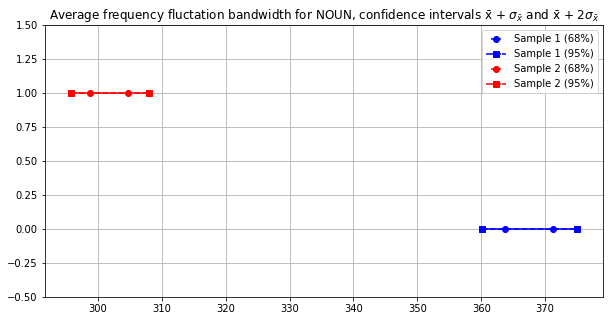

In [32]:
plot_interval_intersection(*avg_freq_fuc())

**CONCLUSION**: Let's assume that there are no significant statistical differences between the fluctuations in the mean frequency of the NOUN and we can combine our samples into one general population (null hypothesis). We can see that our bands of fluctuations in the mean frequency of the NOUN do not overlap in any of the intervals. Therefore, we cannot combine our samples, so we reject the null hypothesis.

## Chi-squared

In [41]:
def calculate_chi_squared(fd_poses1, fd_poses2):
    """
    Calculate Chi-square values for different parts of speech across two subsamples.

    Parameters:
    fd_poses1 (list): List of dictionaries representing subsample M1.
    fd_poses2 (list): List of dictionaries representing subsample M2.

    Returns:
    list: List of Chi-square values for different parts of speech.
    """
    pos_keys = ['NOUN', 'VERB', 'CONJ', 'ADJF', 'NPRO', 'PREP', 'PRCL', 'ADVB', 'GRND', 'NUMR', 'INTJ', 'PRED']
    results = []

    χ_values = {pos: {f'M1': [], f'M2': []} for pos in pos_keys}

    # Gather occurrences for each part of speech in 'M1' and 'M2' subsamples
    for fd_poses, key in zip([fd_poses1, fd_poses2], ['M1', 'M2']):
        for subsample in fd_poses:
            for pos in pos_keys:
                χ_values[pos][key].append(subsample.get(pos, 0))

    # Calculate Chi-square values for each part of speech
    for pos in pos_keys:
        df = pd.DataFrame(χ_values[pos]).T
        df['ΣK'] = df.sum(axis=1)
        df.loc['ΣM'] = df.sum(axis=0)  # Add this line to calculate the sum of each column
        results.append(count_chi_squared(df))

    return results

def count_chi_squared(dataframe):
    """
    Calculates chi-squared based on the dataframe.

    Parameters:
    dataframe (pandas.core.frame.DataFrame): dataframe with M1, M2, ΣK rows and K1-K20 columns.

    Returns:
    float: Chi-square value for the given dataframe.
    """
    m1 = dataframe.iloc[0].values
    m2 = dataframe.iloc[1].values
    sum_K = dataframe.iloc[2].values

    num_m1 = [(m1[k] * m1[k]) / (m1[-1] * sum_K[k]) for k in range(len(m1) - 1)]
    num_m2 = [(m2[k] * m2[k]) / (m2[-1] * sum_K[k]) for k in range(len(m2) - 1)]

    return round(sum_K[-1] * (sum(num_m1 + num_m2) - 1), 2)

In [42]:
calculate_chi_squared(fd_poses1, fd_poses2)

[14.63,
 17.0,
 17.01,
 13.66,
 31.48,
 14.49,
 26.87,
 14.92,
 19.08,
 15.01,
 21.74,
 20.37]

## Student's t-test

In [43]:
import math
import pandas as pd

def calculate_t_test(dataframe1, dataframe2):
    """
    Calculate Student's t-test.

    Parameters:
    dataframe1 (pandas.core.frame.DataFrame): DataFrame with calculated POS statistics for sample 1.
    dataframe2 (pandas.core.frame.DataFrame): DataFrame with calculated POS statistics for sample 2.

    Returns:
    float: Actual Student's t-test value.
    """
    sum_squared_diff1 = dataframe1['(Xi - x̄)²Ni'].sum()
    sum_squared_diff2 = dataframe2['(Xi - x̄)²Ni'].sum()
    n1 = dataframe1['Ni'].sum()
    n2 = dataframe2['Ni'].sum()

    s1 = sum_squared_diff1 / (n1 * (n1 - 1))
    s2 = sum_squared_diff2 / (n2 * (n2 - 1))

    mean_difference = math.fabs(dataframe1['x̄'][1] - dataframe2['x̄'][1])
    t_test_value = mean_difference / math.sqrt(s1 + s2)

    return t_test_value

In [44]:
students_values = []
Xi2 = calculate_chi_squared(fd_poses1, fd_poses2)  # Assuming you have defined calculate_Xi_2 function

for pos in ['NOUN', 'VERB', 'CONJ', 'ADJF', 'NPRO', 'PREP', 'PRCL', 'ADVB', 'GRND', 'NUMR', 'INTJ', 'PRED']:
    data1 = other_statistics(count_prestats(subsamples_1, fd_pos1, 'pos', pos))
    data2 = other_statistics(count_prestats(subsamples_2, fd_pos2, 'pos', pos))
    students_values.append(calculate_t_test(data1, data2))

final_data = pd.DataFrame({'Part of speech': ['NOUN', 'VERB', 'CONJ', 'ADJF', 'NPRO', 'PREP', 'PRCL', 'ADVB', 'GRND', 'NUMR', 'INTJ', 'PRED'],
                           'χ2': Xi2,
                           "Student's t-test": students_values})
final_data.index += 1
final_data

,Part of speech,χ2,Student's t-test
1,NOUN,14.63,13.301592
2,VERB,17.00,19.736593
3,CONJ,17.01,14.707751
4,ADJF,13.66,24.727799
5,NPRO,31.48,7.314635
6,PREP,14.49,10.609753
7,PRCL,26.87,16.841871
8,ADVB,14.92,8.250851
9,GRND,19.08,7.009225
10,NUMR,15.01,0.142209


**f** = (K - 1)(M - 1) = (20 - 1)(2 - 1) = 19

Taking f = 19 and a 95% confidence level, our critical value for χ² is **30.1**;

Taking the degree of freedom f = n+m-2 = 38 with a 95% confidence level our critical value for student's t-test is **2.04** (we take the closest value to 38, which does not exceed 30).

**CONCLUSION**:
1. The samples are statistically homogeneous with respect to all parts of speech except for the pronoun, because their χ2 is less than the critical value. This means that for all parts of speech except the pronoun, the null hypothesis is accepted;
2. The samples are statistically homogeneous with respect to the numeral, because for it the Student's criterion is less than this critical value. This means that the null hypothesis is accepted for this part of speech.